In [1]:
import numpy as np
import tensorflow as tf
import keras

from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
from tensorflow.keras import backend as K
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow.keras import layers as tfkl
from tensorflow import keras as tfk

import pandas as pd


from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ConvNeXtBase

# Importing custom libraries tailored for this project
import sys
sys.path.append('/kaggle/input/augment5')
import AugmentationHelper


# Setting the seeds for reproducibility
SEED = 42
keras.utils.set_random_seed(SEED)   # Automatically sets all random seeds (Numpy, Tensorflow, Keras)


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## ⏳ Load the Data

In [2]:
# Load the NpzFile
data = np.load("/kaggle/input/cleandata/Dataset_clean.npz")

# Inspect content of the NpzFile: contains two keys "training_set", "test_set"
print(data.keys())

# Extract training_set and test_set
training_set = data.get("training_set")
test_set = data.get("test_set")

# Print the shapes of both sets
print(f"The shape of the training set: {training_set.shape}")
print(f"The shape of the test set: {test_set.shape}")

# Split training set into input images and masks
train_images = training_set[:, 0, :, :]
train_masks = training_set[:, 1, :, :]

# Analyse the values of the grayscale images in the training set
print("---------------------------------------------------")
print("TRAINING SET INPUT IMAGES ANALYSIS")
print(f"The shape of the input images: {train_images.shape}")
print(f"Max pixel value: {train_images.max()}")
print(f"Min pixel value: {train_images.min()}")
print(f"Data type to encode pixel values: {train_images.dtype}")

# Analyse the values of the masks in the training set
print("---------------------------------------------------")
print("TRAINING SET OUTPUT MASKS ANALYSIS")
print(f"The shape of the output masks: {train_masks.shape}")
print(f"Max pixel value: {train_masks.max()}")
print(f"Min pixel value: {train_masks.min()}")
print(f"Data type to encode pixel values: {train_masks.dtype}")

# Analyse the values of the grayscale images in the test set
print("---------------------------------------------------")
print("TEST SET ANALYSIS")
print(f"Max pixel value: {test_set.max()}")
print(f"Min pixel value: {test_set.min()}")
print(f"Data type to encode pixel values: {test_set.dtype}")


KeysView(NpzFile '/kaggle/input/cleandata/Dataset_clean.npz' with keys: training_set, test_set)
The shape of the training set: (2102, 2, 64, 128)
The shape of the test set: (10022, 64, 128)
---------------------------------------------------
TRAINING SET INPUT IMAGES ANALYSIS
The shape of the input images: (2102, 64, 128)
Max pixel value: 254
Min pixel value: 2
Data type to encode pixel values: uint8
---------------------------------------------------
TRAINING SET OUTPUT MASKS ANALYSIS
The shape of the output masks: (2102, 64, 128)
Max pixel value: 4
Min pixel value: 0
Data type to encode pixel values: uint8
---------------------------------------------------
TEST SET ANALYSIS
Max pixel value: 255
Min pixel value: 1
Data type to encode pixel values: uint8


In [3]:
# 10% of input data to validation sets
validation_ratio = 0.1

initial_data = (train_images, train_masks)

# Function offered by Keras utils to split the initial data and generate datasets automatically
train_dataset, validation_dataset = keras.utils.split_dataset(
    initial_data, 
    left_size=1-validation_ratio, 
    right_size=validation_ratio,
    shuffle=True
    )

# Extract some metrics
TRAIN_SIZE = tf.data.experimental.cardinality(train_dataset)
VALIDATION_SIZE = tf.data.experimental.cardinality(validation_dataset)

print(f"Training dataset type specification: {train_dataset.element_spec}")
print(f"Validation dataset type specification: {validation_dataset.element_spec}")

print(f"Training dataset size {tf.data.experimental.cardinality(train_dataset)}")
print(f"Validation dataset size {tf.data.experimental.cardinality(validation_dataset)}")

Training dataset type specification: (TensorSpec(shape=(64, 128), dtype=tf.uint8, name=None), TensorSpec(shape=(64, 128), dtype=tf.uint8, name=None))
Validation dataset type specification: (TensorSpec(shape=(64, 128), dtype=tf.uint8, name=None), TensorSpec(shape=(64, 128), dtype=tf.uint8, name=None))
Training dataset size 1892
Validation dataset size 210


In [4]:
# SETTING PARAMETERS TO PROPAGATE IN THE NOTEBOOK FOR TRAINING

# Set number of classes
NUM_CLASSES = 5

# Set batch size for training
BATCH_SIZE = 32

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 200

## Preprocessing

- Augmentation (only training dataset)
- Scaling of image values

In [5]:
def one_hot_encoding(image, mask):
    tf.ensure_shape(mask, (64, 128))
    mask = tf.one_hot(mask, depth=NUM_CLASSES, dtype=tf.uint8)
    return image, mask

# Reshape the input images to (64, 128, 1) and normalise to [0,1]
def reshape_input(image, mask):
    scaled_image = tf.cast(image, tf.float32) / 255
    reshaped_image = tf.expand_dims(scaled_image, axis=-1)
    return reshaped_image, mask

# Define the entire data flow into a single function
def data_flow(dataset, augment=True):

    if augment:
        aug_geometric_1 = dataset.map(AugmentationHelper.map_geometric_transform, num_parallel_calls=tf.data.AUTOTUNE)
        aug_geometric_2 = dataset.map(AugmentationHelper.map_geometric_transform, num_parallel_calls=tf.data.AUTOTUNE)
        aug_intensity = dataset.map(AugmentationHelper.map_intensity_transform, num_parallel_calls=tf.data.AUTOTUNE)
        aug_total_1 = dataset.map(AugmentationHelper.map_total_transform, num_parallel_calls=tf.data.AUTOTUNE)
        aug_total_2 = dataset.map(AugmentationHelper.map_total_transform, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.concatenate(aug_geometric_1).concatenate(aug_geometric_2).concatenate(aug_intensity).concatenate(aug_total_1).concatenate(aug_total_2)

    # Reshape the images to have a third dimension (models expect this shape)
    dataset = dataset.map(reshape_input, num_parallel_calls=tf.data.AUTOTUNE)

    # Modify masks to be one hot encoded
    dataset = dataset.map(one_hot_encoding, num_parallel_calls=tf.data.AUTOTUNE)

    # Shuffle the result
    dataset = dataset.shuffle(buffer_size=tf.data.experimental.cardinality(dataset))
    
    # Batch the dataset
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    #

    return dataset


In [6]:
# Create the datasets
print("Creating datasets...")

train_dataset = data_flow(train_dataset)

validation_dataset = data_flow(validation_dataset, augment=False)

print("Datasets created!")

Creating datasets...
Datasets created!


In [7]:
# NOTICE: THIS TRIGGERS THE WHOLE DATA PIPELINE SO IT TAKES A WHILE, ONLY EXECUTE FOR TESTING
# Check the shape of the data
for batch_images, batch_masks in train_dataset.take(1):
    print(f"TRAINING DATASET - A batch of images has the shape {batch_images.shape}")
    print(f"TRAINING DATASET - A batch of masks has the shape: {batch_masks.shape}")

for batch_images, batch_masks in validation_dataset.take(1):
    print(f"VALIDATION DATASET - A batch of images has the shape {batch_images.shape}")
    print(f"VALIDATION DATASET - A batch of masks has the shape: {batch_masks.shape}")


TRAINING DATASET - A batch of images has the shape (32, 64, 128, 1)
TRAINING DATASET - A batch of masks has the shape: (32, 64, 128, 5)
VALIDATION DATASET - A batch of images has the shape (32, 64, 128, 1)
VALIDATION DATASET - A batch of masks has the shape: (32, 64, 128, 5)


## Build the Model

In [8]:
input_shape=(64,128,1)

def u_net(input_shape=input_shape, depth=4, 
          d_conv_count = 3, b_conv_count = 3, u_conv_count = 3, 
          start_filter=32, skip_connections=True, dropout=0.2):

    # Input Layer
    inputs = tfkl.Input(shape=input_shape, name='input_layer')

    x = inputs
    skipped = []
    # Downsampling
    for i in range(depth):
        for j in range(d_conv_count):
            x = tfkl.Conv2D(filters=start_filter,
                            kernel_size=(3,3),
                            strides=(1, 1),
                            padding='same')(x)
            x = tfkl.BatchNormalization()(x) 
            x = tfkl.ReLU()(x)

        if skip_connections:
            # Save the layer for skip connections
            skipped.append(x)

        x = tfkl.MaxPooling2D(pool_size=(2,2))(x)
        x = tfkl.Dropout(dropout)(x)
        
        start_filter = start_filter * 2
    
    # Bottleneck
    for j in range(b_conv_count):
        x = tfkl.Conv2D(filters=start_filter,
                            kernel_size=(3,3),
                            strides=(1, 1),
                            padding='same')(x)
        x = tfkl.BatchNormalization()(x) 
        x = tfkl.ReLU()(x)
    
    start_filter = start_filter // 2

    # Upsampling
    for i in range(depth):
        x = tfkl.UpSampling2D(2, interpolation='bilinear')(x)

        if skip_connections:
            x = tfkl.Concatenate()([x, skipped[depth - i - 1]])

        x = tfkl.Dropout(dropout)(x)

        for j in range(u_conv_count):
            x = tfkl.Conv2D(filters=start_filter,
                            kernel_size=(3,3),
                            strides=(1, 1),
                            padding='same')(x)
            x = tfkl.BatchNormalization()(x) ## remove?
            x = tfkl.ReLU()(x)
        start_filter = start_filter // 2
    

    # Output Layer
    outputs = tfkl.Conv2D(filters=NUM_CLASSES,
                        kernel_size=(1,1),
                        strides=(1, 1),
                        padding='same',
                        activation='softmax',
                        name="output_layer")(x)
    
    model = tf.keras.Model(inputs, outputs, name='UNet')
    return model

In [9]:
model = u_net()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d (Conv2D)   │ (None, 64, 128, │       320 │ input_layer[0… │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       128 │ conv2d[0][0]   │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu (ReLU)      │ (None, 64, 128, │         0 │ batch_normali… │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_1 (Conv2D) │ (None, 64, 128, │     9,248 │ re_lu[0][0]    │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       128 │ conv2d_1[0][0] │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu_1 (ReLU)    │ (None, 64, 128, │         0 │ batch_normali… │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_2 (Conv2D) │ (None, 64, 128, │     9,248 │ re_lu_1[0][0]  │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       128 │ conv2d_2[0][0] │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu_2 (ReLU)    │ (None, 64, 128, │         0 │ batch_normali… │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 32, 64,  │         0 │ re_lu_2[0][0]  │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dropout (Dropout) │ (None, 32, 64,  │         0 │ max_pooling2d… │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_3 (Conv2D) │ (None, 32, 64,  │    18,496 │ dropout[0][0]  │   Y   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 32, 64,  │       256 │ conv2d_3[0][0] │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu_3 (ReLU)    │ (None, 32, 64,  │         0 │ batch_normali… │   -   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_4 (Conv2D) │ (None, 32, 64,  │    36,928 │ re_lu_3[0][0]  │   Y   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 32, 64,  │       256 │ conv2d_4[0][0] │   Y 

 Total params: 11,791,365 (44.98 MB)

 Trainable params: 11,782,533 (44.95 MB)

 Non-trainable params: 8,832 (34.50 KB)

### Metrics

In [10]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)
        y_true = tf.math.argmax(y_true, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

In [11]:
# https://stackoverflow.com/questions/65125670/implementing-multiclass-dice-loss-function
def dice_loss(y_true, y_pred, smooth=1e-7):
    '''
    Dice coefficient for X categories. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    
    # Remove the background class (class 0)
    y_true = y_true[..., 1:]  # Shape: [batch_size, height, width, num_classes - 1]
    y_pred = y_pred[..., 1:]  # Shape: [batch_size, height, width, num_classes - 1]
    
    # Flatten y_true and y_pred
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    # Compute intersection and denominator
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    
    return K.mean((2. * intersect / (denom + smooth)))

def dice_loss_multiclass(y_true, y_pred):
    '''
    Dice loss to minimize. Pass to model as loss during compile statement
    '''
    return 1 - dice_loss(y_true, y_pred)

def combined_multiclass_loss(y_true, y_pred, alpha=0.5, beta=0.5):
    dice = dice_loss_multiclass(y_true, y_pred)
    categorical_ce = tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred)
    return alpha * dice + beta * categorical_ce

# TODO
# boundary loss

In [12]:
# Compile the model
print("Compiling model...")
model.compile(
    loss= dice_loss_multiclass, #combined_multiclass_loss,#keras.losses.CategoricalFocalCrossentropy(), #dice_loss_multiclass, #tf.keras.losses.Dice, #tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)
print("Model compiled!")

Compiling model...
Model compiled!


## 🛠️ Train the Model

In [13]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    mode="auto",
    min_lr=1e-5
)

In [14]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

Epoch 1/200


I0000 00:00:1733856420.795287      63 service.cc:145] XLA service 0x7a05980a24d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733856420.795342      63 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/354 ━━━━━━━━━━━━━━━━━━━━ 30s 88ms/step - accuracy: 0.1850 - loss: 0.7937 - mean_iou: 0.0645     

I0000 00:00:1733856448.964123      63 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


354/354 ━━━━━━━━━━━━━━━━━━━━ 169s 93ms/step - accuracy: 0.3985 - loss: 0.5791 - mean_iou: 0.1942 - val_accuracy: 0.4257 - val_loss: 0.5292 - val_mean_iou: 0.2731 - learning_rate: 0.0010
Epoch 2/200
354/354 ━━━━━━━━━━━━━━━━━━━━ 121s 77ms/step - accuracy: 0.4843 - loss: 0.4611 - mean_iou: 0.3155 - val_accuracy: 0.4449 - val_loss: 0.5074 - val_mean_iou: 0.2898 - learning_rate: 0.0010
Epoch 3/200
354/354 ━━━━━━━━━━━━━━━━━━━━ 119s 76ms/step - accuracy: 0.4941 - loss: 0.4518 - mean_iou: 0.3132 - val_accuracy: 0.4348 - val_loss: 0.5204 - val_mean_iou: 0.1931 - learning_rate: 0.0010
Epoch 4/200
354/354 ━━━━━━━━━━━━━━━━━━━━ 120s 77ms/step - accuracy: 0.5089 - loss: 0.4321 - mean_iou: 0.3408 - val_accuracy: 0.5088 - val_loss: 0.4400 - val_mean_iou: 0.3180 - learning_rate: 0.0010
Epoch 5/200
354/354 ━━━━━━━━━━━━━━━━━━━━ 120s 77ms/step - accuracy: 0.5149 - loss: 0.4250 - mean_iou: 0.3414 - val_accuracy: 0.6212 - val_loss: 0.3147 - val_mean_iou: 0.4610 - learning_rate: 0.0010
Epoch 6/200
354/354 ━━

In [15]:
# Save the trained model to a file with the accuracy included in the filename
model_filename = 'model.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

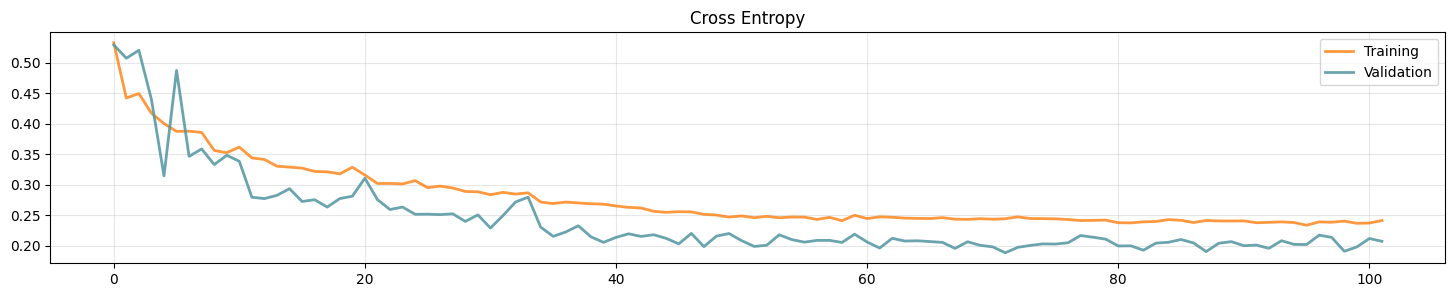

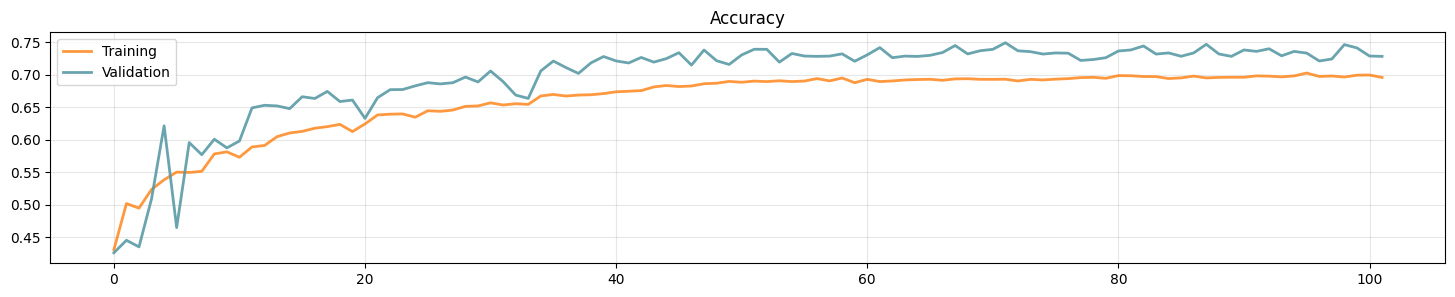

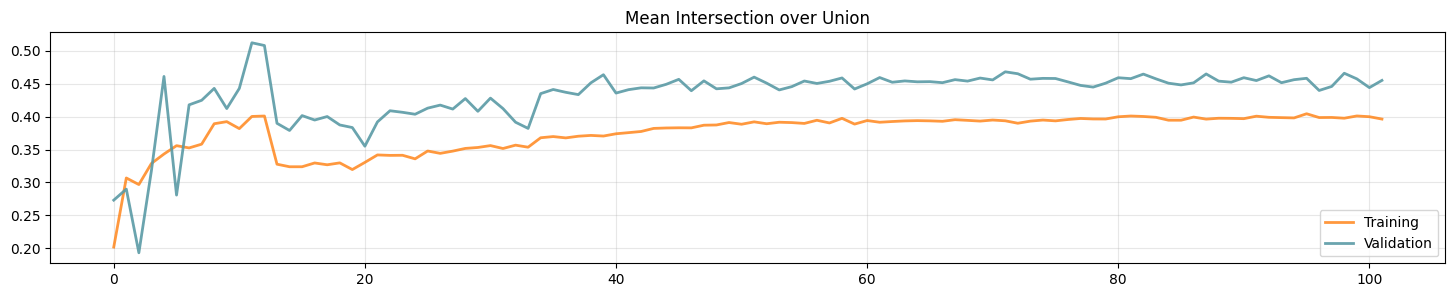

In [16]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.

In [17]:
X_test_submission = data["test_set"]
print(f"Test X shape: {X_test_submission.shape}")
X_test_submission = X_test_submission[..., np.newaxis] / 255.0
X_test_submission = tf.cast(X_test_submission, tf.float32)
#X_test_submission = tf.image.grayscale_to_rgb(X_test_submission)

Test X shape: (10022, 64, 128)


In [18]:
# Load UNet model without compiling
model = tfk.models.load_model('/kaggle/working/model.keras', compile=False)

# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d (Conv2D)   │ (None, 64, 128, │       320 │ input_layer[0… │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       128 │ conv2d[0][0]   │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu (ReLU)      │ (None, 64, 128, │         0 │ batch_normali… │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_1 (Conv2D) │ (None, 64, 128, │     9,248 │ re_lu[0][0]    │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       128 │ conv2d_1[0][0] │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu_1 (ReLU)    │ (None, 64, 128, │         0 │ batch_normali… │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_2 (Conv2D) │ (None, 64, 128, │     9,248 │ re_lu_1[0][0]  │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       128 │ conv2d_2[0][0] │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu_2 (ReLU)    │ (None, 64, 128, │         0 │ batch_normali… │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 32, 64,  │         0 │ re_lu_2[0][0]  │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dropout (Dropout) │ (None, 32, 64,  │         0 │ max_pooling2d… │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_3 (Conv2D) │ (None, 32, 64,  │    18,496 │ dropout[0][0]  │   Y   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 32, 64,  │       256 │ conv2d_3[0][0] │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu_3 (ReLU)    │ (None, 32, 64,  │         0 │ batch_normali… │   -   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_4 (Conv2D) │ (None, 32, 64,  │    36,928 │ re_lu_3[0][0]  │   Y   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 32, 64,  │       256 │ conv2d_4[0][0] │   Y 

 Total params: 11,791,365 (44.98 MB)

 Trainable params: 11,782,533 (44.95 MB)

 Non-trainable params: 8,832 (34.50 KB)

In [19]:
preds = model.predict(X_test_submission)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step
Predictions shape: (10022, 64, 128)


In [20]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

# Create and download the csv submission file
submission_filename = f"submission.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)